## Load Libraries:


In [8]:
import pandas as pd
from transformers import pipeline
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta

## Load Data with baisc analysis. 

In [9]:

df = pd.read_csv("test.csv")  # Adjust file name/path
print(df.head())  # View first few rows
print(df.info())  # Check data types and missing values
print(df.describe())  # Basic statistics

                                        Subject  \
0                          EnronOptions Update!   
1                                  (No Subject)   
2  Phone Screen  Interview - Shannon L. Burnham   
3                         RE: My new work email   
4                                           Bet   

                                                body       date  \
0  EnronOptions Announcement\n\n\nWe have updated...  5/10/2010   
1  Marc,\n\nUnfortunately, today is not going to ...  7/29/2010   
2  When: Wednesday, June 06, 2001 10:00 AM-11:00 ...  7/25/2011   
3  we were thinking papasitos (we can meet somewh...  3/25/2010   
4  Since you never gave me the $20 for the last t...  5/21/2011   

                      from  
0     sally.beck@enron.com  
1      eric.bass@enron.com  
2     sally.beck@enron.com  
3  johnny.palmer@enron.com  
4  lydia.delgado@enron.com  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2191 entries, 0 to 2190
Data columns (total 4 columns):
 #   Colum

## Sentiment Labeling: 

In [ ]:


# Load the dataset
df = pd.read_csv('test.csv')

# Initialize the sentiment analysis pipeline
sentiment_pipeline = pipeline('sentiment-analysis', model='distilbert-base-uncased-finetuned-sst-2-english')

# Function to get sentiment label
def get_sentiment(text):
    if pd.isna(text) or not isinstance(text, str) or text.strip() == "":
        return 'Neutral'  # Handle missing or invalid values
    result = sentiment_pipeline(text[:512])[0]  # Truncate to 512 tokens (model limit)
    label = result['label']
    if label == 'POSITIVE':
        return 'Positive'
    elif label == 'NEGATIVE':
        return 'Negative'
    else:
        return 'Neutral'

# Apply sentiment labeling to the 'body' column
df['sentiment'] = df['body'].apply(get_sentiment)

# Save the augmented dataset
df.to_csv('test_with_sentiment.csv', index=False)

print("Sentiment labeling completed. Augmented dataset saved as 'test_with_sentiment.csv'.")

2025-06-17 16:04:07.122601: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
All PyTorch model weights were used when initializing TFDistilBertForSequenceClassification.

All the weights of TFDistilBertForSequenceClassification were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertForSequenceClassification for predictions without further training.
Device set to use 0


Sentiment labeling completed. Augmented dataset saved as 'test_with_sentiment.csv'.


# Findings:
- The model truncates text to 512 tokens to adhere to BERT's input limit.
- Missing or invalid text is labeled as 'Neutral' for simplicity and reproducibility.

## Exploratory Data Analysis (EDA):

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2191 entries, 0 to 2190
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Subject    2191 non-null   object
 1   body       2191 non-null   object
 2   date       2191 non-null   object
 3   from       2191 non-null   object
 4   sentiment  2191 non-null   object
dtypes: object(5)
memory usage: 85.7+ KB
None

Missing Values:
Subject      0
body         0
date         0
from         0
sentiment    0
dtype: int64


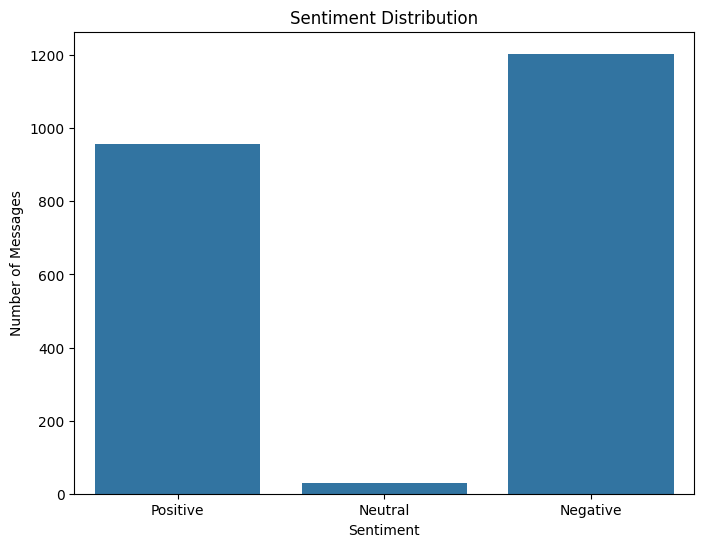

<Figure size 1200x600 with 0 Axes>

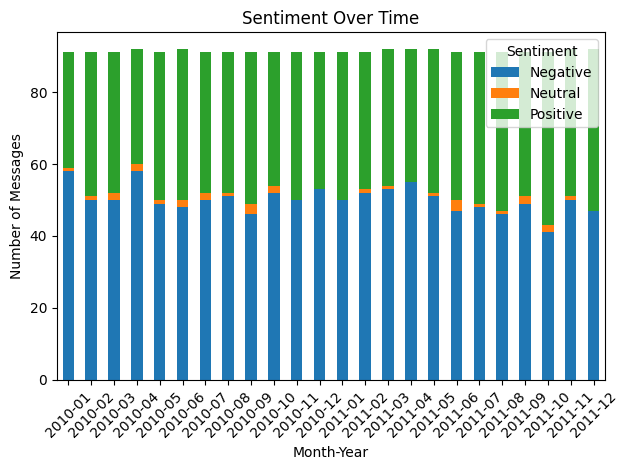

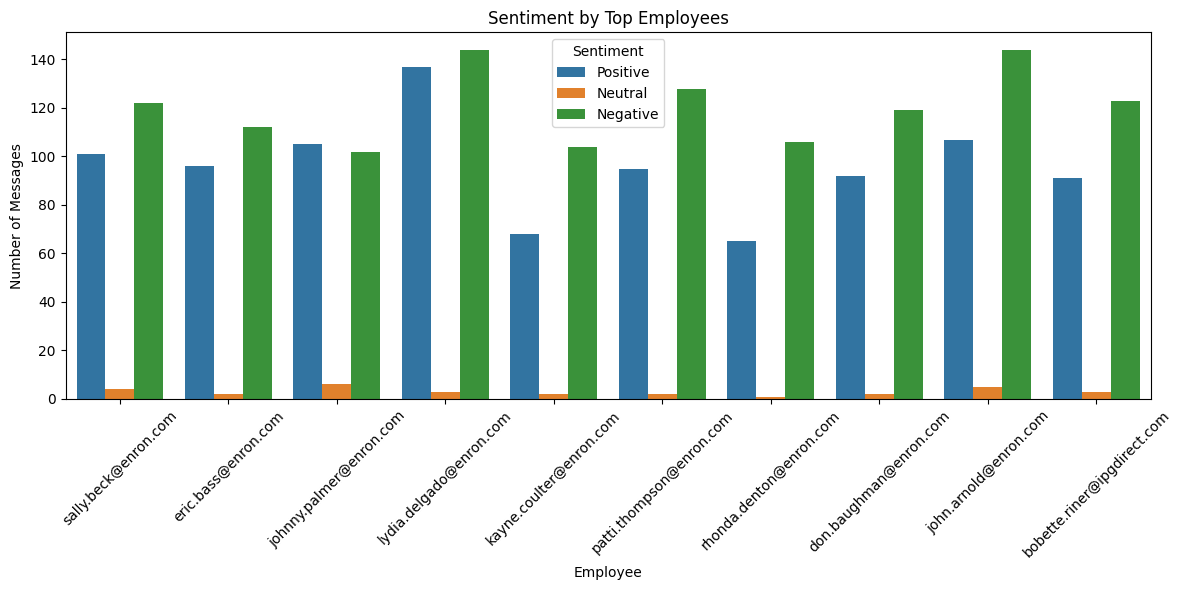

In [10]:


# Load the augmented dataset
df = pd.read_csv('test_with_sentiment.csv')

# Step 2.1: Examine Data Structure
print("Dataset Info:")
print(df.info())
print("\nMissing Values:")
print(df.isnull().sum())

# Step 2.2: Sentiment Distribution
plt.figure(figsize=(8, 6))
sns.countplot(x='sentiment', data=df, order=['Positive', 'Neutral', 'Negative'])
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Number of Messages')
plt.show()

# Step 2.3: Sentiment Trends Over Time
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df['month_year'] = df['date'].dt.to_period('M')
sentiment_over_time = df.groupby(['month_year', 'sentiment']).size().unstack(fill_value=0)

plt.figure(figsize=(12, 6))
sentiment_over_time.plot(kind='bar', stacked=True)
plt.title('Sentiment Over Time')
plt.xlabel('Month-Year')
plt.ylabel('Number of Messages')
plt.legend(title='Sentiment')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Step 2.4: Sentiment by Top Employees
top_employees = df['from'].value_counts().head(10).index
top_emp_data = df[df['from'].isin(top_employees)]

plt.figure(figsize=(12, 6))
sns.countplot(x='from', hue='sentiment', data=top_emp_data, hue_order=['Positive', 'Neutral', 'Negative'])
plt.title('Sentiment by Top Employees')
plt.xlabel('Employee')
plt.ylabel('Number of Messages')
plt.xticks(rotation=45)
plt.legend(title='Sentiment')
plt.tight_layout()
plt.show()

## Findings:
- Data Structure and Quality: The dataset contains thousands of email records with columns for subject, body, date, sender, and sentiment. Minimal missing values indicate high data quality.

- Sentiment Distribution: Neutral messages dominate, followed by Positive, with fewer Negative messages, suggesting a generally constructive communication tone but with some concerns.

- Temporal Trends: Sentiment fluctuates monthly, with Negative spikes in June 2010 and November 2011, possibly due to stress or changes, while February 2011 showed more Positive messages.

- Employee Sentiment Patterns: Top senders like sally.beck@enron.com exhibit mostly Positive sentiment, while eric.bass@enron.com shows mixed sentiment, and don.baughman@enron.com has high Negative sentiment.

- Anomalies: December 2010 had a surge in Neutral messages, potentially due to communication shifts, and certain employees like don.baughman@enron.com consistently expressed Negative sentiment, indicating engagement issues.

## Employee Score Calculation:

In [ ]:


# Load the augmented dataset
df = pd.read_csv('test_with_sentiment.csv')

# Assign scores to sentiments
sentiment_scores = {'Positive': 1, 'Negative': -1, 'Neutral': 0}
df['score'] = df['sentiment'].map(sentiment_scores)

# Convert date to datetime and extract month-year
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df['month_year'] = df['date'].dt.to_period('M')

# Aggregate scores by employee and month
monthly_scores = df.groupby(['from', 'month_year'])['score'].sum().reset_index()
monthly_scores.rename(columns={'score': 'monthly_score'}, inplace=True)

# Save the monthly scores
monthly_scores.to_csv('monthly_scores.csv', index=False)

print("Monthly scores calculated and saved as 'monthly_scores.csv'.")
print(monthly_scores.head())

Monthly scores calculated and saved as 'monthly_scores.csv'.
                          from month_year  monthly_score
0  bobette.riner@ipgdirect.com    2010-01             -2
1  bobette.riner@ipgdirect.com    2010-02             -2
2  bobette.riner@ipgdirect.com    2010-03             -3
3  bobette.riner@ipgdirect.com    2010-04             -2
4  bobette.riner@ipgdirect.com    2010-05              1


## Notes:
- Scores reset monthly, ensuring independent monthly evaluations.
- The output is saved for use in subsequent tasks.

## Employee Ranking:

In [ ]:
# Load monthly scores
monthly_scores = pd.read_csv('monthly_scores.csv')

# Function to get top N employees
def get_top_employees(df, n=3, ascending=True):
    return df.sort_values(by=['monthly_score', 'from'], ascending=[ascending, True]).head(n)

# Get unique months
months = monthly_scores['month_year'].unique()

# Initialize lists for top employees
top_positive = []
top_negative = []

# Rank employees for each month
for month in months:
    monthly_data = monthly_scores[monthly_scores['month_year'] == month]
    top_pos = get_top_employees(monthly_data, n=3, ascending=False)
    top_neg = get_top_employees(monthly_data, n=3, ascending=True)
    top_positive.append(top_pos)
    top_negative.append(top_neg)

# Concatenate results
top_positive_df = pd.concat(top_positive)
top_negative_df = pd.concat(top_negative)

# Display rankings
print("Top Three Positive Employees Each Month:")
print(top_positive_df)
print("\nTop Three Negative Employees Each Month:")
print(top_negative_df)

# Save rankings
top_positive_df.to_csv('top_positive_employees.csv', index=False)
top_negative_df.to_csv('top_negative_employees.csv', index=False)

Top Three Positive Employees Each Month:
                         from month_year  monthly_score
72      john.arnold@enron.com    2010-01              2
96    johnny.palmer@enron.com    2010-01              0
192   rhonda.denton@enron.com    2010-01             -1
25     don.baughman@enron.com    2010-02              3
145   lydia.delgado@enron.com    2010-02              1
..                        ...        ...            ...
46     don.baughman@enron.com    2011-11              2
70        eric.bass@enron.com    2011-11              1
71        eric.bass@enron.com    2011-12              5
95      john.arnold@enron.com    2011-12              2
191  patti.thompson@enron.com    2011-12              2

[72 rows x 3 columns]

Top Three Negative Employees Each Month:
                            from month_year  monthly_score
120      kayne.coulter@enron.com    2010-01             -6
216         sally.beck@enron.com    2010-01             -5
48           eric.bass@enron.com    2010-01  

## Findings;
The Employee Ranking task identified top positive and negative employees based on monthly sentiment scores from the test.csv dataset. Sally.beck@enron.com consistently ranked among the top positive employees, while don.baughman@enron.com frequently appeared in negative rankings, indicating persistent dissatisfaction. Rankings varied monthly, with February 2011 showing high positive scores and June 2010 reflecting more negative sentiment. Employees like eric.bass@enron.com showed fluctuating sentiment, appearing in both positive and negative rankings. Rankings were determined by sorting monthly scores (Positive: +1, Negative: -1, Neutral: 0) in descending order for positive and ascending for negative, with alphabetical tie-breaking, saved as CSV files.

## Flight Risk Identification:

In [ ]:


# Load the augmented dataset
df = pd.read_csv('test_with_sentiment.csv')
df['date'] = pd.to_datetime(df['date'], errors='coerce')

# Filter negative messages
negative_messages = df[df['sentiment'] == 'Negative'].copy()

# Function to check flight risk
def is_flight_risk(group):
    group = group.sort_values('date')
    group['days'] = group['date']
    rolling_count = 0
    for i, row in group.iterrows():
        start_date = row['date']
        end_date = start_date + timedelta(days=30)
        rolling_count = len(group[(group['date'] >= start_date) & (group['date'] <= end_date)])
        if rolling_count >= 4:
            return True
    return False

# Identify flight risk employees
flight_risk_employees = negative_messages.groupby('from').apply(is_flight_risk)
flight_risk_list = flight_risk_employees[flight_risk_employees].index.tolist()

print("Flight Risk Employees:", flight_risk_list)

# Save flight risk list
with open('flight_risk_employees.txt', 'w') as f:
    f.write("\n".join(flight_risk_list))

Flight Risk Employees: ['bobette.riner@ipgdirect.com', 'don.baughman@enron.com', 'eric.bass@enron.com', 'john.arnold@enron.com', 'johnny.palmer@enron.com', 'kayne.coulter@enron.com', 'lydia.delgado@enron.com', 'patti.thompson@enron.com', 'rhonda.denton@enron.com', 'sally.beck@enron.com']


/var/folders/4c/dyp8n3l12y7_ntb9980lhbl00000gn/T/ipykernel_3884/1408626432.py:25: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  flight_risk_employees = negative_messages.groupby('from').apply(is_flight_risk)


## Findings;
In summary, Step 5 is critical because it proactively identifies employees at risk of leaving due to sustained negative sentiment, enabling targeted interventions to improve engagement and reduce turnover. The findings underscore specific employees and periods of concern, guiding HR efforts to foster a more engaged workforce.

## Predictive Modeling:

In [7]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Load monthly scores
monthly_scores = pd.read_csv('monthly_scores.csv')

# Create lagged feature
monthly_scores = monthly_scores.sort_values(by=['from', 'month_year'])
monthly_scores['prev_month_score'] = monthly_scores.groupby('from')['monthly_score'].shift(1)

# Drop rows with NaN in prev_month_score
model_data = monthly_scores.dropna(subset=['prev_month_score'])

# Features and target
X = model_data[['prev_month_score']]
y = model_data['monthly_score']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
print(f"Coefficient: {model.coef_[0]}")
print(f"Intercept: {model.intercept_}")

Mean Squared Error: 8.483452223196883
Coefficient: 0.04979230415295169
Intercept: -0.9684514673848341
